In [8]:
compare = "output/Plummer_profile_1D" # file name (in the folder "data/model_comparison") of the comparison to be made
consider_models = "all" # list of 4 digit hexa string or "all"
exclude_models = ["0000","0001","0002","0003","0004","0005","0007"] # list of 4 digit hexa string or empty list

In [9]:
# Loading models

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import json
import pandas as pd
from scipy.signal import savgol_filter
import yaml
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import Image, display

source = f"data/model_comparison/{compare}.yml"

with open(source) as f:
    archives = yaml.safe_load(f)

models = {}

print("Comparing models:")
for model_number, archive in archives.items():

    try:

        details = json.load(open(f'{archive}/details.json'))
        model_id = details["model_id"]

        if consider_models != "all"\
                and model_id not in consider_models\
                or model_id in exclude_models:
            continue

        history = np.load(f'{archive}/history.npz', allow_pickle=True)
        content = np.load(f'{archive}/predictions.npz', allow_pickle=True)
        predictions = content["predictions"].item()
        expectations = content["expectations"].item()

        print(f" - {model_number}: {archive}/details.json")
        print(f"      History keys: {', '.join(list(history.keys()))}")
        
        models[model_id] = {
            "archive": archive,
            "details": details,
            "history": history,
            "predictions": predictions,
            "expectations": expectations
        }
    except:
        print("Could not load model", model_number)



Comparing models:
Could not load model 0008
Could not load model 0009
Could not load model 000a
Could not load model 000b
Could not load model 000c
Could not load model 000d
Could not load model 000e
 - 000f: ./archives/2023-04-21_21111fc/20/details.json
      History keys: loss, Plummer_profile_1D_loss, Total_mass_loss, Plummer_profile_1D_MAE, Total_mass_MAE, val_loss, val_Plummer_profile_1D_loss, val_Total_mass_loss, val_Plummer_profile_1D_MAE, val_Total_mass_MAE
 - 0010: ./archives/2023-04-21_21111fc/21/details.json
      History keys: loss, Plummer_profile_1D_loss, Total_mass_loss, Plummer_profile_1D_MAE, Total_mass_MAE, val_loss, val_Plummer_profile_1D_loss, val_Total_mass_loss, val_Plummer_profile_1D_MAE, val_Total_mass_MAE
 - 0011: ./archives/2023-04-21_21111fc/22/details.json
      History keys: loss, Plummer_profile_1D_loss, Total_mass_loss, Plummer_profile_1D_MAE, Total_mass_MAE, val_loss, val_Plummer_profile_1D_loss, val_Total_mass_loss, val_Plummer_profile_1D_MAE, val_Total

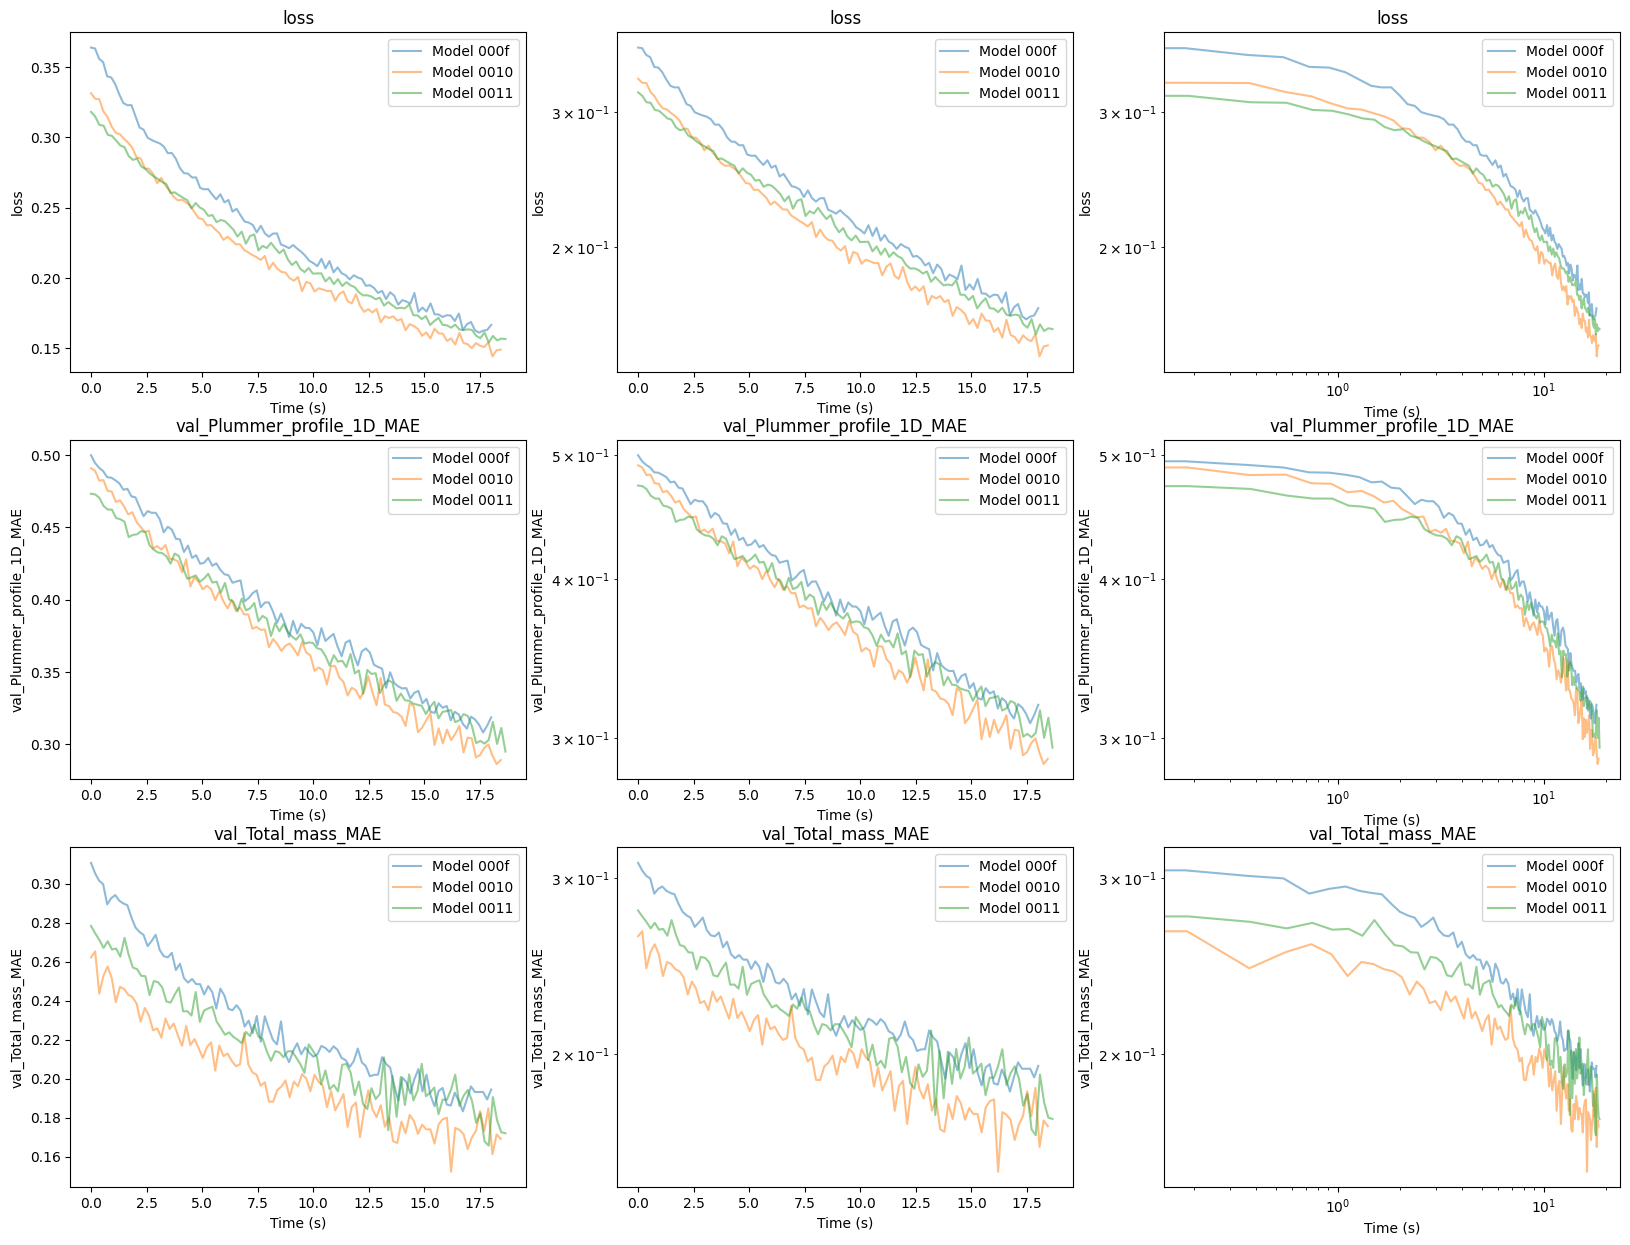

In [10]:
# Plot training evolution

# Looking at how many different val metrics are available
nb_metrics = 1
seen_metrics = ["loss"]
for model_id, model in models.items():
    for key in model["history"].keys():
        if key.startswith("val_") and not key.endswith("loss") and key not in seen_metrics:
            seen_metrics.append(key)
            nb_metrics += 1

fig, axs = plt.subplots(nb_metrics, 3, figsize=(20, 5*nb_metrics))

for model_id, model in models.items():

    history = model["history"]
    time_range = np.linspace(0, model["details"]["training_time"], model["details"]["epochs"], endpoint=True)

    # Printing loss
    for i, key in enumerate(seen_metrics):
        if key in history:
            for ax in axs[i]:
                curve = history[key]
                ax.plot(time_range, curve, alpha=0.5, label=f"Model {model_id}")


for i, row in enumerate(axs):
    for ax in row:
        ax.set_title(seen_metrics[i])
        ax.set_ylabel(seen_metrics[i])
        ax.set_xlabel('Time (s)')
        ax.legend()
    row[1].set_yscale('log')
    row[2].set_xscale('log')
    row[2].set_yscale('log')

plt.show()

SelectMultiple(description='Models', index=(0, 1, 2), options=('000f', '0010', '0011'), value=('000f', '0010',…

SelectionRangeSlider(description='Range', index=(0, 87), layout=Layout(width='100%'), options=('2.11e-10', '2.…

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

(10, 3)
(10, 5, 3)


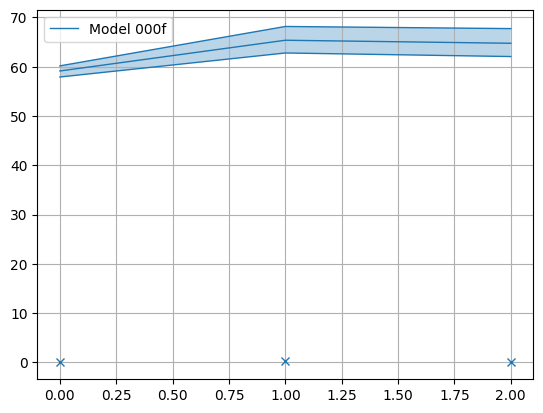

In [38]:
# Prediction distributions

#==============================================================================
# Violin plots (scalar predictions)
#==============================================================================


def violin_plot(output, model_list, limits):
    plt.figure(figsize=(20, 10))

    labels = []
    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    i = 0
    for key in model_list:
        model = models[key]

        predictions = np.array(model["predictions"][output])
        
        expectations = np.array(model["expectations"][output])        

        vmin = float(limits[0])
        vmax = float(limits[1])
        eps = float(limits[0]) * 0.02

        mask = ((expectations + eps >= vmin) & (expectations - eps <= vmax)).flatten()

        filtered_predictions = predictions[mask]
        filtered_predictions = filtered_predictions.reshape(filtered_predictions.shape[0:2]).T
        filtered_expectations = expectations[mask]
        filtered_expectations = filtered_expectations.reshape(filtered_expectations.shape[0]).T

        emin = np.min(filtered_expectations)
        emax = np.max(filtered_expectations)

        plt.plot([emin,emax],[emin,emax], c="black", linewidth=1)

        # for i, prediction in enumerate(filtered_predictions):
        #     filtered_predictions[i] = prediction - filtered_expectations

        

        violin_parts = plt.violinplot(
            dataset=filtered_predictions[:,:],
            positions=filtered_expectations[:], 
            widths=(np.max(filtered_expectations)-np.min(filtered_expectations))*0.05, showmeans=True, showextrema=True
        )

        add_label(violin_parts, f"Model {key}")


        # model_id = model["details"]["model_id"]
        
        # color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        # i+=1

        # first = True
        # for prediction in filtered_predictions:
        #     if first:
        #         plt.scatter(filtered_expectations, prediction, alpha=0.5, s=10, c=color, label=f"Model {model_id}")
        #         first = False
        #     else:
        #         plt.scatter(filtered_expectations, prediction, alpha=0.5, s=10, c=color)
        
 
    plt.title(f'Model predictions on {output}')
    plt.ylabel('Predictions')
    plt.xlabel('Expected')
    plt.ticklabel_format(axis="both", style='sci', scilimits=(0,0))
    plt.grid()
    plt.legend(*zip(*labels), loc=2)
    plt.show()

#==============================================================================
# Thick line plots (vector predictions)
#==============================================================================

def thick_line_plot(output, model_list, limits):

    color_number = 0
    for key in model_list:
        model = models[key]
        model_id = model["details"]["model_id"]
        color = color = plt.rcParams['axes.prop_cycle'].by_key()['color'][color_number]
        color_number += 1

        expectations = np.array(model["expectations"][output])
        predictions = np.array(model["predictions"][output])

        print(expectations.shape)
        print(predictions.shape)
    

        p_top = [np.max(predictions[0,:,j]) for j in range(predictions.shape[2])]
        p_mean = [np.mean(predictions[0,:,j]) for j in range(predictions.shape[2])]
        p_bot = [np.min(predictions[0,:,j]) for j in range(predictions.shape[2])]


        plt.plot(expectations[0], "x", c=color)
        r = np.arange(len(p_top))
        plt.plot(p_top, c=color, linewidth=1, label=f"Model {model_id}")
        plt.plot(p_mean, c=color, linewidth=1)
        plt.plot(p_bot, c=color, linewidth=1)
        plt.fill(np.concatenate([r, r[::-1]]), np.concatenate([p_top, p_bot[::-1]]), alpha=.3, fc=color, ec='None')
        break

    plt.legend()
    plt.grid()
    plt.show()

#==============================================================================
# Map plots (vector predictions)
#==============================================================================

# TODO

#==============================================================================
# GUI
#==============================================================================

if compare.startswith("output/"):
    outputs = [compare.split("/")[1]]
elif compare.startswith("problem/"):
    outputs = compare.split("/")[1].split("---")[1].split(",")
else:
    raise ValueError("Invalid compare argument")

model_list_select = widgets.SelectMultiple(
    options=list(models.keys()),
    value=list(models.keys()),
    description='Models',
    disabled=False
)

sample_model = models[list(models.keys())[0]]
output_widget = Dropdown(options=outputs, value=outputs[0], description="Output: ")

def get_possible_expectations():
    possible_expectations = np.array([])
    for model in models.values():
        possible_expectations = np.concatenate((
            possible_expectations,
            model["expectations"][output_widget.value].flatten()
        ))

    possible_expectations = list(map(lambda x: f"{x:.2e}", np.sort(possible_expectations).tolist()))
    return possible_expectations

expectation_slider = widgets.SelectionRangeSlider(
    options=get_possible_expectations(),
    index=(0, len(get_possible_expectations())-1),
    description='Range',
    disabled=False,
    width='100%',
    layout=Layout(width='100%')  
)

plot_button = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def update_violin_plot(*args):
    clear_output()
    display(model_list_select)
    if len(outputs) > 1:
        display(output_widget)
    display(expectation_slider)
    display(plot_button)

    output_shape = sample_model["expectations"][output_widget.value].shape[1:]
    if output_shape in [(1,),()]:
        violin_plot(output_widget.value, model_list_select.value, expectation_slider.value)
    elif len(output_shape) == 1:
        thick_line_plot(output_widget.value, model_list_select.value, expectation_slider.value)


plot_button.on_click(update_violin_plot)

update_violin_plot()

In [12]:
# Select model and view details

def print_model_details(id):

    model = models[id]
    archive = model["archive"]
    details = model["details"]

    display(Image(filename=f'{archive}/model.png'))
    print("\n".join(details['summary'][-4:]))

    print("")
    print("Optimizer:", details['optimizer'])
    if isinstance(details['loss'], list):
        print("Loss:\n -", "\n - ".join(details['loss']))
    else:
        print("Loss:", details['loss'])
    print("Metrics:\n -", "\n - ".join(details['metrics']))
    print("")
    print("Epochs:", details['epochs'])
    print("Batch size:", details['batch_size'])
    print("")
    print(f"Training time: {int(details['training_time']//60)}m {details['training_time']%60:.2f}s" )
    print("Score:\n -", "\n - ".join([f"{i:.2e}" for i in details['scores']]))
    print("")
    # print("Dataset size:", details['dataset_size'])
    print("Validation fraction:", int(details['val_frac'] * 100), "%")
    print("Test fraction:", int(details['test_frac'] * 100), "%")
    print("")
    print("Path:", archive)
    print("")
    if "inputs" in details:
        print("Inputs:\n -", "\n - ".join(details['inputs']))
    if "outputs" in details:
        print("Outputs:\n -", "\n - ".join(details['outputs']))


options = [hex(i)[2:] for i in range(len(archives))]
for i, option in enumerate(options):
    options[i] = "0"*(4 - len(option)) + option

selected_model = models[options[0]]

model_widget = Dropdown(options=options, value=options[0], description="Model ID: ")

# Define a function that updates the content of y based on what we select for x
def update_model_widget(*args):
    global selected_model
    clear_output()
    display(model_widget)
    print_model_details(model_widget.value)
    selected_model = models[model_widget.value]

model_widget.observe(update_model_widget)
update_model_widget()

KeyError: '0000'